## Training :

In [47]:
def load_train(train_path, image_size, classes):
    images = []
    labels = []
    img_names = []
    cls = []

    print('Going to read training images')
    for fields in classes:   
        index = classes.index(fields)
        print('Now going to read {} files (Index: {})'.format(fields, index))
        path = os.path.join(train_path, fields)
        #print(path)
        files = glob.glob(path)
        #print(files)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
            image = image.astype(np.float32)
            image = np.multiply(image, 1.0 / 255.0)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            print(labels)
            img_names.append(flbase)
            cls.append(fields)
    images = np.array(images)
    labels = np.array(labels)
    img_names = np.array(img_names)
    cls = np.array(cls)
    #print(images,'........', labels,'.......',img_names,'.......', cls)
    return images, labels, img_names, cls



In [48]:
import os,glob,cv2
import numpy as np
#Prepare input data
classes = os.listdir('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train/')
num_classes = len(classes)

if('.DS_Store' in classes):
    classes.remove('.DS_Store')
print(classes)
# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 128
num_channels = 6
train_path='/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train/'
images, labels, img_names, cls=load_train(train_path, img_size, classes)

['chicago.jpg', 'tushar.jpg', 'chicago copy.jpg']
Going to read training images
Now going to read chicago.jpg files (Index: 0)
[array([1., 0., 0.])]
Now going to read tushar.jpg files (Index: 1)
[array([1., 0., 0.]), array([0., 1., 0.])]
Now going to read chicago copy.jpg files (Index: 2)
[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]


In [49]:
def next_batch(images, labels, img_names, cls,batch_size):
    """Return the next `batch_size` examples from this data set."""
    num_examples = images.shape[0]
    #print('num_examples=',num_examples)
    index_in_epoch=0
    start = index_in_epoch
    epochs_done=0
    index_in_epoch += batch_size

    if index_in_epoch > num_examples:
      # After each epoch we update this
        epochs_done += 1
        start= 0
        index_in_epoch = batch_size
        #assert batch_size <= num_examples
    end = index_in_epoch

    return images[start:end], labels[start:end], img_names[start:end], cls[start:end]



In [50]:
from sklearn.utils import shuffle
def read_train_sets(train_path, image_size, classes, validation_size):
    images, labels, img_names, cls = load_train(train_path, image_size, classes)
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)  
    #print(images, labels, img_names, cls)
    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])
 
    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]

    train = next_batch(train_images, train_labels, train_img_names, train_cls,batch_size)
    valid = next_batch(validation_images, validation_labels, validation_img_names, validation_cls,batch_size)
    return train,valid

In [51]:
import tensorflow as tf
import time
from datetime import timedelta
import math
import random
import numpy as np
import os

#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


batch_size = 32

#Prepare input data
classes = os.listdir('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train/')
if('.DS_Store' in classes):
    classes.remove('.DS_Store')
num_classes = len(classes)
print(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 128
num_channels = 3
train_path='/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train/'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
data_t,data_v = read_train_sets(train_path, img_size, classes, validation_size=validation_size)

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(len(data_t)))
print("Number of files in Validation-set:\t{}".format(len(data_v)))



session = tf.Session()
x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


['chicago.jpg', 'tushar.jpg', 'chicago copy.jpg']
Going to read training images
Now going to read chicago.jpg files (Index: 0)
[array([1., 0., 0.])]
Now going to read tushar.jpg files (Index: 1)
[array([1., 0., 0.]), array([0., 1., 0.])]
Now going to read chicago copy.jpg files (Index: 2)
[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		4
Number of files in Validation-set:	4


In [31]:
##Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))



def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)

    return layer

    

def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input,          
             num_inputs,    
             num_outputs,
             use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)

layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
          
layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False) 

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer()) 


def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

total_iterations = 0

saver = tf.train.Saver()
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = next_batch(data_t[0],data_t[1],data_t[2],data_t[3],batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = next_batch(data_v[0],data_v[1],data_v[2],data_v[3],batch_size)

        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)
        data_t_img_shape=data_t[0].shape[0]
#         if (data_t_img_shape !=0):
#             if i % int(data_t_img_shape/batch_size) == 0: 
        val_loss = session.run(cost, feed_dict=feed_dict_val)
        epoch = int(i / int(32/batch_size))    

        show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
        saver.save(session, '/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/model') 


    total_iterations += num_iteration

train(num_iteration=20)



Training Epoch 1 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 2 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 3 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 4 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 5 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 6 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 7 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 8 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 9 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training Epoch 10 --- Training Accuracy: 100.0%, Validation Accuracy:   nan%,  Validation Loss: nan
Training 

## Testing

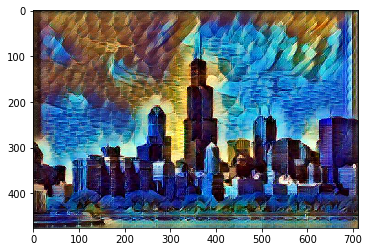

In [35]:
import tensorflow as tf
import numpy as np
import os,glob,cv2
import sys,argparse
from matplotlib import pyplot as plt

# First, pass the path of the image
dir_path = os.path.dirname(os.path.realpath('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train'))
image_path='chicago copy.jpg'
filename = dir_path +'/' +image_path
image_size=128
num_channels=3

# Reading the image using OpenCV
image = cv2.imread('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train/chicago copy.jpg')
plt.imshow(image)
plt.show()

In [36]:
images = []
# Resizing the image to our desired size and preprocessing will be done exactly as done during training
image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
images.append(image)
images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0) 
#The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
x_batch = images.reshape(1, image_size,image_size,num_channels)

## Let us restore the saved model 
sess = tf.Session()
# Step-1: Recreate the network graph. At this step only graph is created.
savr = tf.train.import_meta_graph('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/model.meta')
# Step-2: Now let's load the weights saved using the restore method.
savr.restore(sess, tf.train.latest_checkpoint('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/'))

# Accessing the default graph which we have restored
graph = tf.get_default_graph()

# Now, let's get hold of the op that we can be processed to get the output.
# In the original network y_pred is the tensor that is the prediction of the network
y_pred = graph.get_tensor_by_name("y_pred:0")

## Let's feed the images to the input placeholders
x= graph.get_tensor_by_name("x:0") 
y_true = graph.get_tensor_by_name("y_true:0") 
y_test_images = np.zeros((1, len(os.listdir('/Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/train')))) 
print(y_test_images)

### Creating the feed_dict that is required to be fed to calculate y_pred 
feed_dict_testing = {x: x_batch, y_true: y_test_images}
result=sess.run(y_pred, feed_dict=feed_dict_testing)
# result is of this format [probabiliy_of_rose probability_of_sunflower]
print(result)




INFO:tensorflow:Restoring parameters from /Users/roshnidas/Documents/BDS-FinalProject/fast-style-transfer/examples/model
[[0. 0. 0.]]
[[0.30527776 0.31443393 0.38028824]]


In [37]:
y_test_images

array([[0., 0., 0.]])